In [67]:
livia_dir = (os.path.abspath(os.path.join(os.path.dirname("C:/Users/feder/Documents/CUAHSI/repos/Aquaholics_Anonymous/Topmodel_with_physics/model_1.0_anyDEM.ipynb"), '..','..'))
+ '/hydrological-model/code/')
#sys.path.append(livia_dir)
data_dir = (os.path.abspath(os.path.join(os.path.dirname("C:/Users/feder/Documents/CUAHSI/repos/Aquaholics_Anonymous/Topmodel_with_physics/model_1.0_anyDEM.ipynb"), '..',))
+ '/data/hubbard_brook/')
sys.path.append(data_dir)


In [113]:
import sys
import os
import os.path
import time

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import osr
from osgeo.gdalconst import *

In [109]:
#from RasterHandler import createRanRasterSlope
import matplotlib.pyplot as mp
import Flow as Flow
#import Driver as Driver
from RasterHandler import readRaster

#sys.path.append('../hydrological-model/code/')


#print(sys.path)
#from Raster import Raster

In [110]:
dem_file = data_dir + "hubbard_clipped.tif"
ascii_dem_file = data_dir + "ascii_hubbard_clipped.txt"
os.system('gdal_translate -of AAIGrid ' + dem_file + ' ' + ascii_dem_file)

0

In [111]:
def readRaster(fileName):
    """Generates a raster object from a ARC-INFO ascii format file
    
    """
    #print("UN ENORME VAFFANCULO")
    lines = []
    myFile=open(fileName,'r')
        
    end_header=False
    xll=0.
    yll=0.
    nodata=-999.999
    cellsize=1.0
    
    while (not end_header):
        line=myFile.readline()    
        items=line.split()
        keyword=items[0].lower()
        value=items[1]
        if (keyword=='ncols'):
            ncols=int(value)
        elif (keyword=='nrows'):
            nrows=int(value)
        elif (keyword=='xllcorner'):
            xll=float(value)
        elif (keyword=='yllcorner'):
            yll=float(value)  
        elif (keyword=='nodata_value'):
            nodata=float(value)
        elif (keyword=='cellsize'):
            cellsize=float(value)
        elif (keyword=='dx'):
            cellsize1=float(round(float(value)))
        elif (keyword=='dy'):
            cellsize2=float(round(float(value)))
            if cellsize1 == cellsize2 or cellseize == cellsize1:
                print("Cellsize {} is correct".format(cellsize))
        else:
            end_header=True
    
    if (nrows==None or ncols==None):
        print ("Row or Column size not specified for Raster file read")
        return None  

    items=line.split()
        
    datarows=[]
    items=line.split()
    
    row=[]
    for item in items:
        row.append(float(item))
 
    datarows.append(row)
        
    for line in myFile.readlines():
        lines.append(line)
        items=line.split()
        row=[]
        for item in items:
            row.append(float(item))
   
        datarows.append(row)

    data=np.array(datarows)
    
    return Raster(data,xll,yll,cellsize,nodata)
    
    
def createRanRaster(rows=20,cols=30,cellsize=1,xorg=0,yorg=0,nodata=-999.999,levels=5,datahi=100.,datalo=0.):
   """Creates a random raster"""
   levels=min(levels,rows)
   levels=min(levels,cols)
   data=np.zeros([levels,rows,cols])  
   dataout=np.zeros([rows,cols]) 
   
   for x in np.nditer(data,op_flags=['readwrite']):
       x[...]=random.uniform(datalo,datahi) 

   

   
   for i in range(levels):
       lin=((i)*2)+1
       lin2=lin*lin
       iterator=np.zeros([lin2,2], dtype=int)
       for itx in range(lin):
           for ity in range(lin):
               iterator[itx*lin+ity,0]=(itx-i)
       
       part=data[i]
      
       new=np.zeros([rows,cols])
       for j in range(rows):
           for k in range(cols):
                for it in range(lin2):
                        r=(j+iterator[it,0])%rows
                        c=(k+iterator[it,1])%cols
                        new[j,k]=new[j,k]+part[r,c]
        
       minval=np.min(new)
       maxval=np.max(new)
       ran=maxval-minval
       data[i]=((new-minval)/ran)*(2**i)
       
       dataout=dataout+data[i]
       
   minval=np.min(dataout)
   maxval=np.max(dataout)
   ran=maxval-minval
   datarange=datahi-datalo
   dataout=(((dataout-minval)/ran)*(datarange))+datalo
   return Raster(dataout,xorg,yorg,cellsize,nodata)
   

def createRanRasterSlope(rows=20,cols=30,cellsize=1,xorg=0,yorg=0,nodata=-999.999,levels=5,datahi=100.,datalo=0.,focusx=None,focusy=None,ranpart=0.5):
    """Generates a Random Slope Raster
    """
    if (focusx==None):
        focusx=cols/2
    if (focusy==None):
        focusy=rows/2
        
    rast=createRanRaster(rows,cols,cellsize,xorg,yorg,nodata,levels,1.,0.)

    slope_data=np.zeros([rows,cols])
    maxdist=math.sqrt(rows*rows+cols*cols)
    
    for i in range(rows):
        for j in range(cols):
            xd=focusx-j
            yd=focusy-i
            dist=maxdist-math.sqrt((xd*xd)+(yd*yd))
            slope_data[i,j]=dist/maxdist
            
    minval=np.min(slope_data)
    maxval=np.max(slope_data)
    ran=maxval-minval
   
    slope_data=((slope_data-minval)/ran)
    
    ran_data=rast.getData()
    
    data_out=slope_data*(1.-ranpart)+ran_data*(ranpart)
    minval=np.min(data_out)
    maxval=np.max(data_out)
    ran=maxval-minval
    datarange=datahi-datalo
    data_out=(((data_out-minval)/ran)*datarange)+datalo
        
    return Raster(data_out,xorg,yorg,cellsize)

def plotstreams(flownode,colour):
    """Recursively plots upnodes in given colour
    
    Input Parameter:
        flownode – a FlowNode object
        colour – a colour, e.g. "red"
    """
    for node in flownode.getUpnodes():
        x1=flownode.get_x()
        y1=flownode.get_y()
        x2=node.get_x()
        y2=node.get_y()
        mp.plot([x1,x2],[y1,y2],color=colour)
        if (node.numUpnodes()>0):
            plotstreams(node,colour)

def plotFlowNetwork(originalRaster, flowRaster, title="", plotLakes=True):
    """Plots a flow network
    
    Input Parameter:
        originalRaster – a Raster object
        flowRaster – a FlowRaster object
        title – plot title, a string
        plotLake – binary variable stating if lakes should be plotted
                    True if lakes should be plotted
                    False if lakes should be ignored
    """
    print ("\n\n{}".format(title))
    mp.imshow(originalRaster.extractValues(Flow.ElevationExtractor()))
    mp.colorbar()
    colouri=-1
    colours=["black","red","magenta","yellow","green","cyan","white","orange","grey","brown"]

    for i in range(flowRaster.getRows()):
        for j in range(flowRaster.getCols()):
            node = flowRaster._data[i,j]
            
            if (node.getPitFlag()): # dealing with a pit
                mp.scatter(node.get_x(),node.get_y(), color="red")
                colouri+=1
                plotstreams(node, colours[colouri%len(colours)])
                
            if (plotLakes and node.getLakeDepth() > 0): #if lakedepth is zero, it is not a lake
                mp.scatter(node.get_x(),node.get_y(), color="blue")

    mp.show()

def plotExtractedData(flowRaster, extractor, title=""):
    """Plots extracted data
    
    Input Parameter:
        flowRaster – FlowRaster class object
        extractor – FlowExtractor class object, or LakedepthExtractor object
        title – String of chart title
    """
    print ("\n\n{}".format(title))
    mp.imshow(flowRaster.extractValues(extractor))
    mp.colorbar()
    mp.show()

def plotRaster(araster, title=""):
    """Plots a raster
    
    Input Parameter:
        araster – Raster class object
        title – plot title, a string
    """
    print ("\n\n{}, shape is  {}".format(title, araster.shape))
    mp.imshow(araster)
    mp.colorbar()
    mp.show()


def calculateFlowsAndPlot(elevation, rain, resampleF):
    """Calculates all the flows and plots them
    
    Input Parameter:
        elevation – a Raster class object containing elevation
        rain – a Raster class object containing rainfall
        resampleF – an Integer
    
    """
    
    # plot input rasters
    plotRaster(elevation.getData(), "Original elevation (m)") #plot elevation
    plotRaster(rain.getData(), "Rainfall") #plot rainfall

    resampledElevations = elevation.createWithIncreasedCellsize(resampleF)
    print(resampledElevations)

    
    
    
    ################# step 1 find and plot the intial network #######
    print("Start step 1")
    fr=Flow.FlowRaster(resampledElevations) #create FlowRaster
    #plotFlowNetwork(fr, fr, "Task 1: Network structure - before lakes", plotLakes=False) #plot flow raster
    print("End step 1")

    ################Step 2 ######################################
    print("Start step 2")
    plotExtractedData(fr, Flow.FlowExtractor(1), "Task 2: River flow rates - constant rain")
    print("End step 2")
    
    
    ################# step 3 #######################################
    #handle variable rainfall
    print("Start step 3")
    fr.addRainfall(rain.getData())
    plotExtractedData(fr, Flow.FlowExtractor(), "Task 3: River flow rates - variable rainfall")
    
    ############# step 4 and step 5 #######################################
    # handle lakes
    print("Start step 4")
    fr.calculateLakes()

    plotFlowNetwork(fr, fr, "Task 4: Network structure (i.e. watersheds) - with lakes")
    plotExtractedData(fr, Flow.LakeDepthExtractor(), "Task 4: Lake depth")
    plotExtractedData(fr, Flow.FlowExtractor(), "Parallel Flows")
    
    #TESTING
    #this line tests if total raster outflow is equal to total rainfall on the raster
    assert round(fr.getTotalFlow(), 2) == round(fr.getTotalRainfall(),2)
    
    
    ############# step 5 #######################################
    print("Start step 5")
    maxflow=fr.getMaximumFlow()
    print("Task 5: Maximum Flow: {} mm, at FlowNode object: {}".format(round(maxflow[0], 3), maxflow[1]))



Cellsize 1.0 is correct


Original elevation (m), shape is  (520, 860)


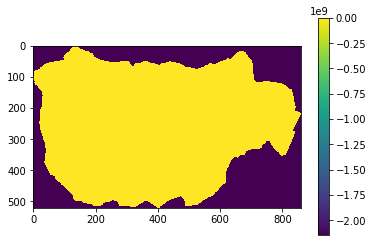



Rainfall, shape is  (520, 860)


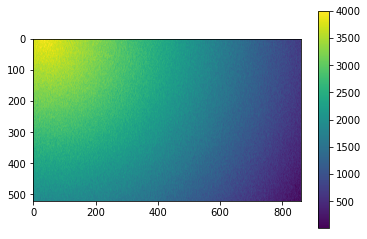



Task 1: Network structure - before lakes


In [ ]:
demRaster = readRaster(ascii_dem_file)
rows=demRaster.getRows()
cols=demRaster.getCols()
xorg=demRaster.getOrgs()[0]
yorg=demRaster.getOrgs()[1]
xp=None
yp=None
nodata=demRaster.getNoData()
cellsize=demRaster.getCellsize()
levels=4
datahi=0.
datalow=0
randpercent=0.3

resampleFactorA = 1
elevationRasterA=createRanRasterSlope(rows,cols,cellsize,xorg,yorg,nodata,levels,datahi,datalow,xp,yp,randpercent)   
rainrasterA=createRanRasterSlope(rows//resampleFactorA,cols//resampleFactorA,cellsize*resampleFactorA,xorg,yorg,nodata,levels,4000,1,36,4,.1)   

##random raster
Driver.calculateFlowsAndPlot(demRaster, rainrasterA, resampleFactorA)

In [103]:
print(cellsize)

10.0


In [49]:
print(sys.path)

['C:\\Users\\feder\\Documents\\CUAHSI\\repos\\Aquaholics_Anonymous\\Topmodel_with_physics', 'C:\\pcraster-4.2.1\\python', 'C:\\Users\\feder\\Documents\\CUAHSI\\repos\\Aquaholics_Anonymous\\Topmodel_with_physics', 'C:\\Users\\feder\\Anaconda3\\python37.zip', 'C:\\Users\\feder\\Anaconda3\\DLLs', 'C:\\Users\\feder\\Anaconda3\\lib', 'C:\\Users\\feder\\Anaconda3', '', 'C:\\Users\\feder\\Anaconda3\\lib\\site-packages', 'C:\\Users\\feder\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\feder\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\feder\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\feder\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\feder\\.ipython', 'C:\\Users\\feder\\Documents\\CUAHSI\\repos/hydrological-model/code/', 'C:\\Users\\feder\\Documents\\CUAHSI\\repos\\Aquaholics_Anonymous/data/hubbard_brook/']
